## Importing some libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string

import spacy

import gensim
from gensim import corpora

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 12.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=17a020e70a019f21fb93a846a4d1e02f8ac12541ea7d095349bce526109139a6
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
df = pd.read_csv('train.csv')

df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
test = pd.read_csv('test.csv')

test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


Since the the task here is to perform topic modeling, only the abstract will be used.

In [ ]:
abstract = df['ABSTRACT']
abstract.head(10)

0      Predictive models allow subject-specific inf...
1      Rotation invariance and translation invarian...
2      We introduce and develop the notion of spher...
3      The stochastic Landau--Lifshitz--Gilbert (LL...
4      Fourier-transform infra-red (FTIR) spectra o...
5      Let $\Omega \subset \mathbb{R}^n$ be a bound...
6      We observed the newly discovered hyperbolic ...
7      The ability of metallic nanoparticles to sup...
8      We model large-scale ($\approx$2000km) impac...
9      Time varying susceptibility of host at indiv...
Name: ABSTRACT, dtype: object

### Cleaning the documents (abstract)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = stopwords.words('english')

def cleaner(doc):
  cleaned_doc = []
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  new_words = tokenizer.tokenize(doc)
  for word in new_words:
    if word not in stops:
      cleaned_doc.append(word)
  cleaned_doc = " ".join(cleaned_doc)
  return cleaned_doc

new_abstract = abstract.apply(lambda x: cleaner(x))
new_abstract.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    Predictive models allow subject specific infer...
1    Rotation invariance translation invariance gre...
2    We introduce develop notion spherical polyharm...
3    The stochastic Landau Lifshitz Gilbert LLG equ...
4    Fourier transform infra red FTIR spectra sampl...
5    Let Omega subset mathbb R n bounded domain sat...
6    We observed newly discovered hyperbolic minor ...
7    The ability metallic nanoparticles supply heat...
8    We model large scale approx 2000km impacts Mar...
9    Time varying susceptibility host individual le...
Name: ABSTRACT, dtype: object

In [ ]:
# Lemmetizing

!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(doc, allowed_postages=['NOUN', 'ADJ']):
  output = []
  for sent in doc:
    texts = nlp(sent)
    output.append([token.lemma_ for token in texts if token.pos_ in allowed_postages])
  return output


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 33.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
print(lemmatization(new_abstract[:20]))

[['predictive', 'model', 'subject', 'specific', 'inference', 'disease', 'alteration', 'neuroimaging', 'datum', 'subject', 'datum', 'inference', 'level', 'global', 'e', 'condition', 'presence', 'subject', 'local', 'e', 'condition', 'effect', 'individual', 'measurement', 'subject', 'datum', 'global', 'inference', 'local', 'inference', 'form', 'subject', 'specific', 'effect', 'map', 'model', 'noisy', 'detection', 'isolated', 'island', 'article', 'reconstruction', 'method', 'rsm', 'subject', 'specific', 'detection', 'predictive', 'modeling', 'approach', 'particular', 'binary', 'classifier', 'noise', 'due', 'sampling', 'error', 'finite', 'sample', 'example', 'train', 'classifier', 'method', 'wrapper', 'type', 'different', 'binary', 'classifier', 'diagnostic', 'manner', 'e', 'information', 'condition', 'presence', 'problem', 'prior', 'model', 'parameter', 'training', 'datum', 'specific', 'fashion', 'evaluation', 'data', 'datum', 'database', 'synthetic', 'datum', 'rsm', 'yield', 'high', 'dete

In [ ]:
abstract_list = new_abstract.tolist()
print(abstract_list[1])
tokenized_abstracts = lemmatization(abstract_list)
print(tokenized_abstracts[1])

Rotation invariance translation invariance great values image recognition tasks In paper bring new architecture convolutional neural network CNN named cyclic convolutional layer achieve rotation invariance 2 D symbol recognition We also get position orientation 2 D symbol network achieve detection purpose multiple non overlap target Last least architecture achieve one shot learning cases using invariance
['rotation', 'invariance', 'translation', 'invariance', 'great', 'value', 'image', 'recognition', 'task', 'paper', 'new', 'architecture', 'convolutional', 'neural', 'network', 'cyclic', 'convolutional', 'layer', 'rotation', 'invariance', 'd', 'symbol', 'recognition', 'position', 'orientation', 'd', 'symbol', 'network', 'detection', 'purpose', 'multiple', 'non', 'overlap', 'target', 'last', 'least', 'architecture', 'shot', 'learning', 'case', 'invariance']


### creating a vocabulary dictionary and document matrix term

In [ ]:
dictionary = corpora.Dictionary(tokenized_abstracts)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_abstracts]

In [ ]:
# Creating the object for LDA model using gensim library

LDA = gensim.models.ldamodel.LdaModel

# Build LDA Model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=6, random_state=42,
                chunksize=1000, passes=100, iterations=500)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
# Printing the topics

lda_model.print_topics()

[(0,
  '0.016*"equation" + 0.009*"system" + 0.009*"mass" + 0.009*"model" + 0.008*"time" + 0.007*"star" + 0.007*"galaxy" + 0.007*"line" + 0.006*"large" + 0.006*"high"'),
 (1,
  '0.031*"network" + 0.019*"model" + 0.015*"datum" + 0.010*"task" + 0.009*"system" + 0.009*"paper" + 0.009*"neural" + 0.009*"learning" + 0.009*"performance" + 0.008*"approach"'),
 (2,
  '0.014*"space" + 0.014*"graph" + 0.013*"group" + 0.011*"function" + 0.011*"result" + 0.010*"paper" + 0.009*"theory" + 0.009*"_" + 0.009*"case" + 0.009*"number"'),
 (3,
  '0.014*"field" + 0.013*"phase" + 0.013*"state" + 0.013*"energy" + 0.010*"temperature" + 0.010*"system" + 0.009*"magnetic" + 0.008*"transition" + 0.008*"spin" + 0.007*"interaction"'),
 (4,
  '0.023*"method" + 0.022*"model" + 0.021*"problem" + 0.011*"datum" + 0.011*"distribution" + 0.011*"function" + 0.010*"time" + 0.009*"parameter" + 0.009*"algorithm" + 0.008*"approach"'),
 (5,
  '0.011*"image" + 0.011*"datum" + 0.009*"system" + 0.009*"method" + 0.008*"time" + 0.007*

In [ ]:
# visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.176100  0.091588       1        1  22.729540
4      0.016791  0.102169       2        1  22.324408
3     -0.093369 -0.112502       3        1  14.020004
5      0.221400 -0.045447       4        1  13.918244
2     -0.214946  0.202635       5        1  13.661086
0     -0.105976 -0.238443       6        1  13.346718, topic_info=           Term          Freq         Total Category  logprob  loglift
86      network   8917.000000   8917.000000  Default  30.0000  30.0000
57      problem   8711.000000   8711.000000  Default  29.0000  29.0000
128    equation   2692.000000   2692.000000  Default  28.0000  28.0000
45       method  10641.000000  10641.000000  Default  27.0000  27.0000
1273      graph   3197.000000   3197.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
693       small    700.768111   2548.993671   Topic6  -5.4938   0.7226
485         low    752.002800   3608.705546   Topic6  -5.4233   0.4455
137      result    736.703385   7909.466013   Topic6  -5.4438  -0.3597
52    parameter    661.825687   3854.821711   Topic6  -5.5510   0.2518
626        rate    629.913875   2678.271506   Topic6  -5.6004   0.5666

[419 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
756       3  0.157503    3d
756       4  0.841980    3d
185       3  0.245851     _
185       5  0.541974     _
185       6  0.212107     _
...     ...       ...   ...
276       2  0.211675  work
276       3  0.098156  work
276       4  0.133435  work
276       5  0.112097  work
276       6  0.035564  work

[725 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 6, 3, 1])

### Model Performance

In [ ]:
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# Getting mallet for topic classification

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-08-16 20:58:07--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-08-16 20:58:08--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.50MB/s    in 2.8s    

2022-08-16 20:58:12 (5.50 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

# Collating the topics

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=6, id2word=dictionary)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_abstracts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -7.487976913778225

Coherence Score:  0.5137417626105542


In [ ]:
from pprint import pprint
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tokenized_abstracts, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('field', 0.013609737575248197),
   ('energy', 0.013114838027057353),
   ('phase', 0.010938986565183818),
   ('state', 0.009885191837570554),
   ('high', 0.009808397080092665),
   ('temperature', 0.007965322900623318),
   ('density', 0.0077648032560977175),
   ('effect', 0.007709340375697019),
   ('low', 0.007683742123204389),
   ('magnetic', 0.007205908076675299)]),
 (1,
  [('space', 0.022194289244797633),
   ('theory', 0.016457968266480605),
   ('group', 0.015105112622569253),
   ('equation', 0.014625754323545547),
   ('type', 0.013299529696246624),
   ('property', 0.012154395981912213),
   ('order', 0.011003936064255317),
   ('condition', 0.010924043014418032),
   ('_', 0.010774909321388434),
   ('result', 0.010705668678196122)]),
 (2,
  [('system', 0.03532377714241558),
   ('user', 0.010407812379259718),
   ('dynamic', 0.010137354145738351),
   ('paper', 0.010113206089173944),
   ('control', 0.00869330036318677),
   ('design', 0.008654663472683718),
   ('information', 0.008

In [ ]:
# Computing coherence values

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_abstracts, start=2, limit=10, step=1)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

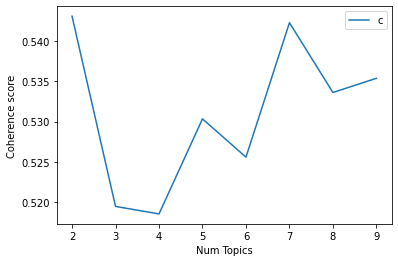

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.543058
Num Topics = 3  has Coherence Value of 0.519496
Num Topics = 4  has Coherence Value of 0.518567
Num Topics = 5  has Coherence Value of 0.530342
Num Topics = 6  has Coherence Value of 0.525602
Num Topics = 7  has Coherence Value of 0.542256
Num Topics = 8  has Coherence Value of 0.533613
Num Topics = 9  has Coherence Value of 0.53537


In [ ]:
model_list

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.020*"high" + 0.017*"large" + 0.014*"time" + 0.011*"low" + 0.011*"scale" + '
  '0.009*"small" + 0.009*"observation" + 0.009*"model" + 0.007*"region" + '
  '0.007*"mass"'),
 (1,
  '0.043*"problem" + 0.032*"method" + 0.022*"model" + 0.016*"algorithm" + '
  '0.016*"distribution" + 0.015*"function" + 0.014*"time" + 0.013*"parameter" '
  '+ 0.012*"matrix" + 0.011*"number"'),
 (2,
  '0.021*"space" + 0.017*"graph" + 0.016*"result" + 0.015*"group" + '
  '0.014*"case" + 0.013*"function" + 0.012*"equation" + 0.012*"number" + '
  '0.012*"class" + 0.011*"type"'),
 (3,
  '0.019*"system" + 0.019*"field" + 0.019*"state" + 0.015*"energy" + '
  '0.013*"phase" + 0.013*"dynamic" + 0.011*"interaction" + 0.011*"structure" + '
  '0.010*"effect" + 0.009*"temperature"'),
 (4,
  '0.046*"model" + 0.033*"network" + 0.021*"approach" + 0.020*"method" + '
  '0.020*"datum" + 0.014*"task" + 0.014*"image" + 0.013*"learning" + '
  '0.013*"performance" + 0.013*"neural"'),
 (5,
  '0.025*"system" + 0.017*"datum" 

In [ ]:
# Finding dominant topics



def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=abstract_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=abstract_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2683,"model, network, approach, method, datum, task,...",Predictive models allow subject specific infer...
1,1,4.0,0.3069,"model, network, approach, method, datum, task,...",Rotation invariance translation invariance gre...
2,2,2.0,0.3793,"space, graph, result, group, case, function, e...",We introduce develop notion spherical polyharm...
3,3,1.0,0.2621,"problem, method, model, algorithm, distributio...",The stochastic Landau Lifshitz Gilbert LLG equ...
4,4,4.0,0.2416,"model, network, approach, method, datum, task,...",Fourier transform infra red FTIR spectra sampl...
5,5,2.0,0.4731,"space, graph, result, group, case, function, e...",Let Omega subset mathbb R n bounded domain sat...
6,6,0.0,0.3507,"high, large, time, low, scale, small, observat...",We observed newly discovered hyperbolic minor ...
7,7,3.0,0.4400,"system, field, state, energy, phase, dynamic, ...",The ability metallic nanoparticles supply heat...
8,8,0.0,0.3044,"high, large, time, low, scale, small, observat...",We model large scale approx 2000km impacts Mar...
9,9,5.0,0.2417,"system, datum, paper, application, user, infor...",Time varying susceptibility host individual le...


In [ ]:
# Finding the most representative document for each topic



# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7062,"high, large, time, low, scale, small, observat...",To understand evolution extinction curve calcu...
1,1.0,0.5992,"problem, method, model, algorithm, distributio...",The paper solves problem optimal portfolio cho...
2,2.0,0.6400,"space, graph, result, group, case, function, e...",It well known normaized characters integrable ...
3,3.0,0.6540,"system, field, state, energy, phase, dynamic, ...",Graphitic nitrogen doped graphene excellent pl...
4,4.0,0.6336,"model, network, approach, method, datum, task,...",Visual question answering recently proposed ar...


In [ ]:
# Topic distribution in all the data


# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Adding the texts to it also.
df_dominant_topics['Abstracts'] = abstract_list

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Abstracts
0.0,4.0,"model, network, approach, method, datum, task,...",1965.0,0.0937,Predictive models allow subject specific infer...
1.0,4.0,"model, network, approach, method, datum, task,...",3779.0,0.1802,Rotation invariance translation invariance gre...
2.0,2.0,"space, graph, result, group, case, function, e...",4570.0,0.2179,We introduce develop notion spherical polyharm...
3.0,1.0,"problem, method, model, algorithm, distributio...",3515.0,0.1676,The stochastic Landau Lifshitz Gilbert LLG equ...
4.0,4.0,"model, network, approach, method, datum, task,...",3595.0,0.1714,Fourier transform infra red FTIR spectra sampl...
...,...,...,...,...,...
20967.0,4.0,"model, network, approach, method, datum, task,...",NaN,NaN,Machine learning finding increasingly broad ap...
20968.0,3.0,"system, field, state, energy, phase, dynamic, ...",NaN,NaN,Polycrystalline diamond coatings grown cemente...
20969.0,4.0,"model, network, approach, method, datum, task,...",NaN,NaN,We present new approach identifying situations...
20970.0,1.0,"problem, method, model, algorithm, distributio...",NaN,NaN,The sum Log normal variates encountered many c...


In [ ]:
df.shape

(20972, 9)

In [ ]:
df_dominant_topics.Dominant_Topic.value_counts()

2.0    4570
1.0    3779
4.0    3595
5.0    3548
3.0    3515
0.0    1965
Name: Dominant_Topic, dtype: int64

### LDA - Method 2.

In [ ]:
# Using SKlearn

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition

In [ ]:
# using tfidf to vectorize the texts

vectorizer_tf = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=30, max_features=20000, use_idf=False, norm=None)
tf_vectors = vectorizer_tf.fit_transform(abstract_list)

In [ ]:
tf_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
vectorizer_tf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '001',
 '01',
 '02',
 '03',
 '04',
 '05',
 '10',
 '100',
 '1000',
 '11',
 '111',
 '12',
 '120',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '1d',
 '20',
 '200',
 '2000',
 '2001',
 '2002',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '21',
 '22',
 '23',
 '24',
 '25',
 '250',
 '26',
 '27',
 '28',
 '29',
 '2d',
 '2k',
 '2n',
 '30',
 '300',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '3d',
 '40',
 '400',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '50',
 '500',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '60',
 '600',
 '62',
 '63',
 '64',
 '65',
 '67',
 '68',
 '69',
 '70',
 '72',
 '73',
 '74',
 '75',
 '77',
 '78',
 '79',
 '80',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '_0',
 '_1',
 '_2',
 '_3',
 '_4',
 '_n',
 '_p',
 '_x',
 'a_',
 'aa',
 'ab',
 'abelian',
 'abilities',


In [ ]:
# Performing LDA

lda = decomposition.LatentDirichletAllocation(n_components=6, max_iter=200, learning_method='online', learning_offset=50, n_jobs=-1, random_state=42)
W1 = lda.fit_transform(tf_vectors)

H1 = lda.components_

In [ ]:
W1

array([[0.59204409, 0.08816448, 0.29800648, 0.01966329, 0.00105898,
        0.00106268],
       [0.66708342, 0.00372521, 0.00372762, 0.00374225, 0.24941762,
        0.07230387],
       [0.00388451, 0.00388992, 0.13094018, 0.05836837, 0.79903822,
        0.0038788 ],
       ...,
       [0.78418256, 0.13562793, 0.00177755, 0.00177443, 0.07486686,
        0.00177067],
       [0.00155727, 0.11500525, 0.82890492, 0.00155117, 0.02698899,
        0.02599241],
       [0.31780458, 0.00268766, 0.67149869, 0.00266283, 0.00267409,
        0.00267214]])

In [ ]:
# classifying the topics and getting the top 15 words that represent each topic


num_words = 15

vocab = np.array(vectorizer_tf.get_feature_names())

top_wprds = lambda t:[vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_wprds(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [ ]:
topics

['data learning based network model networks using neural paper performance deep approach models training results',
 'time model systems control network dynamics power networks paper process flow results processes study different',
 'algorithm problem method data model methods based algorithms proposed problems optimization distribution linear function approach',
 'phase field energy magnetic quantum spin temperature state states transition model surface high wave using',
 'mathbb prove paper space group theory mathcal study results finite graph set functions non case',
 'mass 10 data high star using observations galaxies stars present results large observed emission gas']

In [ ]:
# sorting the document based on the topic percentage and getting the dominant topic


colnames = ['Topic' + str(i) for i in range(lda.n_components)]
doc_names = ['Doc' + str(i) for i in range(len(abstract_list))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=doc_names)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [ ]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.59,0.09,0.30,0.02,0.00,0.00,0
Doc1,0.67,0.00,0.00,0.00,0.25,0.07,0
Doc2,0.00,0.00,0.13,0.06,0.80,0.00,4
Doc3,0.00,0.18,0.29,0.13,0.39,0.00,4
Doc4,0.57,0.00,0.33,0.00,0.00,0.09,0
...,...,...,...,...,...,...,...
Doc20967,0.93,0.00,0.00,0.03,0.04,0.00,0
Doc20968,0.05,0.00,0.00,0.87,0.00,0.07,3
Doc20969,0.78,0.14,0.00,0.00,0.07,0.00,0
Doc20970,0.00,0.12,0.83,0.00,0.03,0.03,2


In [ ]:
# Testing on a part of the document to see its performance.

whold = lda.transform(vectorizer_tf.transform(abstract_list[:5]))

In [ ]:
colnames = ['Topic' + str(i) for i in range(lda.n_components)]
doc_names = ['Doc' + str(i) for i in range(len(abstract_list[:5]))]
df_doc_topic = pd.DataFrame(np.round(whold, 2), columns=colnames, index=doc_names)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [ ]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.59,0.09,0.30,0.02,0.00,0.00,0
Doc1,0.67,0.00,0.00,0.00,0.25,0.07,0
Doc2,0.00,0.00,0.13,0.06,0.80,0.00,4
Doc3,0.00,0.18,0.29,0.13,0.39,0.00,4
Doc4,0.57,0.00,0.33,0.00,0.00,0.09,0


In [ ]:
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
# The result shows that the code works very well.The topic seems to be properly classified.
# This a;so shows that topic 0 denotes computer science, topic 4 represents mathematics.